# Overview 

We design this assignment to help you fully understand probabilistic Latent Semantic Analysis
 (pLSA) and its computation - expectation maximization (EM) algorithm. You will see how pLSA will help identify the underlying topic (i.e., programming language) of the synthetic code snippets. 

In this assignment, you will need to **run through** (i.e., running each code cell sequentially or `Runtime -> Run all`) the following pipeline:

- Preparation:
    - Downloading the dataset and loading required libraries.
    - Inspecting data.
- Part 1 (Q1, Q2): Implementating pLSA based on EM algorithm with unlabeled data only; both of the questions are worth 40 points.
- Part 2 (Q3): Improving your implementation in Part 1 by incorporating labeled data; this question is worth 20 points.
- Making a Submission


**Runtime**: If you implement everything correctly, you will finish running this entire notebook within 3 minutes under `Stevens-Net`. If you are experiencing noticeable delay, check your network condition.

**Library requirement**: You are **NOT** allowed to use existing libraries that have already implemented pLSA algorithms for you; other than these libraries, you are free to choose your preferred libraries.

**Note on Colab**: If a cell contains only a function, you should still run it (so the function compiles in Colab), even though it doesn't print any outputs. 



# Loading Dataset and Importing Libraries

In [176]:
! rm -rf cs589*
! rm -rf submission*

In [177]:
! git clone https://github.com/guanqun-yang/cs589assignment3
! apt-get install tree

Cloning into 'cs589assignment3'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 37 (delta 7), reused 37 (delta 7), pack-reused 0
Unpacking objects: 100% (37/37), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [178]:
import pathlib
import itertools

import numpy as np
import pandas as pd

from tqdm import trange
from collections import Counter
from cs589assignment3.utils.common import (   
    seed_everything,
    post_processing
)

seed_everything(0)

pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 20

save_path = pathlib.Path("submission")
if not save_path.exists(): 
    save_path.mkdir()

# Looking at the Data

The pLSA considers a generatative process. For each $i$-th position of the document $d$ is determined by two distributions:
1. First choose a topic $z_i$:
$$z_i \sim \mathrm{Multinomial}(\theta_d)$$
where $\theta_d$ is the document-topic vector of document $d$; its length is the number of topics of a corpus; this makes $\theta_d \in \mathbb{R}^2$.
2. Then choose a term $w_i$ under the topic in the first step: 
$$w_i \sim \mathrm{Multinomial}(\phi_z)$$
where $\phi_z$ is the topic-word vector for each topic; its length is the number of terms of a topic; this makes $\phi_z \in \mathbb{R}^8$.

In this assignment,
- Our corpus has 2 topics, i.e., Java and Python.
- Our corpus has 8 possible words (i.e., the vocabulary `vocab`); they are all [reserved words](https://en.wikipedia.org/wiki/Reserved_word) for the Java and Python programming languages
```python
vocab = {
    "import", "class", "arraylist", "hashset"
    "hashmap", "lambda", "def", "elif"
}
```

As a developer, we can tell a program is written in Python if it includes `def`, `lambda`, and `elif`; a program is written in Java if it has `arraylist`, `hastset`, and `hashmap`; while `import` and `class` does not provide a lot of information for the underlying language as both languages share them. 

In this assignment, we need to teach the computer to learn about this through pLSA. Let's first look at the data; we have 
- 100 samples that have known topics (Java or Python).
- 10000 samples whose topics are waiting to be discovered.




In [179]:
n_topic = 2
n_word = None
n_doc = None
n_labeled = None

df = pd.read_csv("cs589assignment3/dataset/dataset.txt", 
                 sep="\t", 
                 names=["label", "text"]).convert_dtypes(int)

vocab = set(itertools.chain(*[text.split() for text in df.text.tolist()]))

labeled_df = df[~df.label.isna()]
unlabeled_df = df[df.label.isna()]

In [180]:
print(labeled_df.head())
print(unlabeled_df.head())

   label                 text
0      0  arraylist class ...
1      1  lambda class lam...
2      1  lambda lambda el...
3      0  hashmap hashmap ...
4      1  import elif def ...
     label                 text
100   <NA>  hashmap import h...
101   <NA>  class lambda has...
102   <NA>  import class imp...
103   <NA>  arraylist hashma...
104   <NA>  def elif import ...


In [181]:
token_to_index_dict = {token: index for index, token in enumerate(vocab)}
index_to_token_dict = {v: k for k, v in token_to_index_dict.items()}

In [182]:
# helper function
def format_result(unlabeled_df, topic_word_mat, document_topic_mat):
    topic_word_df = pd.DataFrame(
        topic_word_mat,
        columns=list(token_to_index_dict.keys()),
        index=["Java", "Python"]
        )

    document_topic_df = pd.DataFrame(document_topic_mat, columns=["Java", "Python"])
    document_topic_df = document_topic_df.assign(text=unlabeled_df.text.tolist())

    return topic_word_df, document_topic_df

In [183]:
n_word = len(vocab)

The code snippet below represents each code snippet as vector of size 8, where each entry is the word count.

In [184]:
def get_token_cnt_vector(text):
    # this function depends on n_word and token_to_index_dict variables
    # initialized above

    token_cnt_vector = np.zeros(n_word)

    for token, cnt in Counter(text.split()).items():
        index = token_to_index_dict[token]
        token_cnt_vector[index] = cnt
    
    return token_cnt_vector

labeled_doc_mat = np.vstack(labeled_df.text.apply(get_token_cnt_vector).tolist())
unlabeled_doc_mat = np.vstack(unlabeled_df.text.apply(get_token_cnt_vector).tolist())

For example, let's look at the first labeled document:

In [185]:
print(labeled_df.label.tolist()[0])
print(labeled_df.text.tolist()[0])
print(labeled_doc_mat[0])

0
arraylist class hashmap hashmap arraylist hashmap hashmap hashset hashmap hashmap hashmap hashmap import hashmap class import class hashmap import hashmap hashmap arraylist hashmap hashmap arraylist hashset hashmap hashmap hashset class hashmap import arraylist hashmap arraylist hashmap hashset hashmap hashset hashmap import arraylist arraylist arraylist hashset hashmap import hashset hashset hashset import hashset class hashset hashmap hashset hashmap hashmap import class arraylist hashmap hashset hashset hashset arraylist hashmap import arraylist hashmap arraylist import arraylist hashmap import hashset class import hashmap hashmap class hashset class hashmap hashset hashset import hashmap class hashmap hashmap class arraylist hashmap hashmap import hashset hashmap hashmap class 
[15.  0. 12.  0.  0. 39. 20. 14.]


We have 100 labeled documents and 10000 unlabeled ones; this gives us two matrices of shape `(100, 8)` and `(10000, 8)` respectively.

In [186]:
print(labeled_doc_mat.shape)
print(unlabeled_doc_mat.shape)

(100, 8)
(10000, 8)


The `labeled_df` and `unlabeled_df` may remind you of a typical machine learning setting, where one could predict the labels of 10000 samples given a model trained on 100 labeled samples. But this is **NOT** what we are trying to do in this assignment. Rather, we are trying to

- Part 1: Estimate $\theta_d$ and $\phi_z$ with unlabeled data only using pLSA.
- Part 2: Use the labeled data to improve the estimation in step 1.


# Part 1: pLSA with Unlabeled Data

The E-step and M-step are shown below:

## E-Step

For each document $j=1,2,\cdots, 10000$, each word $i=1,2,\cdots,8$, and each topic $k=1,2$:
- At the 1st iteration, computing $p(z_k\vert w_i, d_j)$ depends on randomly initialized $p(w_i\vert z_k)$ and $p(z_k\vert d_j)$.
- At the rest of iterations, computing $p(z_k\vert w_i, d_j)$ depends on $p(w_i\vert z_k)$ and $p(z_k\vert d_j)$ computed from the last iteration.

$$
p(z_k\vert w_i, d_j) = 
\frac{p(w_i\vert z_k) p(z_k\vert d_j)}{\sum_{k=1}^2p(w_i\vert z_k)p(z_k\vert d_j)}
$$

## M-Step
- For each document $j=1,2,\cdots,10000$, each word $i=1,2,\cdots,8$, and each topic $k=1,2$:
$$
p(w_i\vert z_k)=
\frac{\sum_{j=1}^{10000} n(w_i, d_j) p(z_k\vert w_i, d_j)}{\sum_{m=1}^8\sum_{j=1}^{10000} n(w_m, d_j) p(z_k\vert w_m, d_j)}
$$
where $n(w_m, d_j)$ is the number of appearances of the word $w_m$ in the document $d_j$.
- For each document $j=1,2,\cdots, 10000$, each word $i=1,2,\cdots, 8$, and each topic $k=1,2$:
$$
p(z_k\vert d_j)=
\frac{\sum_{i=1}^{10000} n(w_i, d_j) p(z_k\vert w_i, d_j)}{\sum_{i=1}^{10000} n(w_i, d_j)}
$$
where $n(w_i, d_j)$ is the number of appearances of the word $w_i$ in the document $d_j$.

In code, the $\theta_d$ and $\phi_z$ are represented as `document_topic_mat` and `topic_word_mat` for efficient computation:


- `document_topic_mat`:
$$
    \begin{pmatrix}
    - &\theta_1^T& - \\
    - &\vdots &- \\
    - &\theta_{10000}^T& - \\
    \end{pmatrix}
    \in \mathbb{R}^{10000\times 2} 
$$

- `topic_word_mat`: It is a matrix representing the topic word distribution of the **entire corpus**.

$$
    \begin{pmatrix}
    -&\phi_\mathrm{Java}^{T}&-\\
    -&\phi_\mathrm{Python}^{T}&-
    \end{pmatrix}
    \in \mathbb{R}^{2 \times 8}
$$

Another variable you could see in the code is `pred`:

- `pred`: It is a matrix stacked with 10000 matrices, each representing the topic word distribution of **each document**.

$$
    \begin{pmatrix}
    \begin{pmatrix}
    - &\phi_\mathrm{Java}^{(1)T}&-\\
    -&\phi_\mathrm{Python}^{(1)T}&-
    \end{pmatrix}\\
    \vdots\\
    \begin{pmatrix}
    -&\phi_\mathrm{Java}^{(10000)T}&-\\
    -&\phi_\mathrm{Python}^{(10000)T}&-
    \end{pmatrix}
    \end{pmatrix} \in \mathbb{R}^{10000 \times 2 \times 8}
$$
    



In [187]:
# global variables
n_word = len(vocab)
n_labeled = len(labeled_df)
n_doc = len(unlabeled_df)
n_iteration = 100

## E-Step

In [188]:
def E_step(document_topic_mat, topic_word_mat):   
    """
    Input:
        document_topic_mat: (n_doc, n_topic), probability of each document being one of the topics
        topic_word_mat: (n_topic, n_word), probability of each topic has each word for the entire corpus
    
    Output:
        pred: (n_doc, n_word, n_topic), probability of each topic has each for for each document
    """

    pred = np.zeros((n_doc, n_word, n_topic))

    #############################################START HERE#############################################
    # Question 1 (40 pt)

    numerator = np.zeros((n_doc, n_word, n_topic))

    # Loop variables: j for documents, v for words, k for topics

    # Loop through each document
    for j in range(n_doc):

      # Loop through each word
      for v in range(n_word):
        denominator = 0

        # Loop through each topic
        for k in range(n_topic):
          numerator[j][v][k] = topic_word_mat[k][v] * document_topic_mat[j][k]
          denominator += numerator[j][v][k]

        # Zero division check
        if denominator == 0:
          for k in range(n_topic):
            pred[j][v][k] = 0
        else:
          for k in range(n_topic):
            pred[j][v][k] = numerator[j][v][k] / denominator

    ##############################################END HERE##############################################
    
    return pred

## M-Step


In [189]:
def compute_document_topic_mat(pred, unlabeled_doc_mat):
    """
    Input:
        pred: (n_doc, n_word, n_topic), probability of each topic has each for for each document
        unlabeled_doc_mat: (n_doc, n_word), word count for each document
    
    Output:
        document_topic_mat: (n_doc, n_topic), probability of each document being one of the topics
    """

    document_topic_mat = np.zeros((n_doc, n_topic))
    for j in range(n_doc):
        for v in range(n_word):
            document_topic_mat[j][0] += pred[j][v][0] * unlabeled_doc_mat[j][v]
            document_topic_mat[j][1] += pred[j][v][1] * unlabeled_doc_mat[j][v]
    

    return document_topic_mat

In [190]:
def compute_topic_word_mat(pred, unlabeled_doc_mat):
    """
    Input:
        pred: (n_doc, n_word, n_topic), probability of each topic has each for for each document
        unlabeled_doc_mat: (n_doc, n_word), word count for each document
    
    Output:
        topic_word_mat: (n_topic, n_word), probability of each topic has each word for the entire corpus
    """
    topic_word_mat = np.zeros((n_topic, n_word))

    ##############################################START HERE##############################################
    # Question 2 (40 pt)

    numerator = np.zeros((n_topic, n_word))

    for k in range(n_topic):
      denominator = 0

      for v in range(n_word):
        numerator[k][v] = 0

        for j in range(n_doc):
          numerator[k][v] += unlabeled_doc_mat[k][v] * pred[j][v][k]

        denominator += numerator[k][v]

        # Zero division check
        if denominator == 0:
          for v in range(n_word):
            topic_word_mat[k][v] = 1.0 / n_word
        else:
          for v in range(n_word):
            topic_word_mat[k][v] = numerator[k][v] / denominator
            
    ##############################################END HERE################################################
    

    return topic_word_mat

In [191]:
def M_step(pred, unlabeled_doc_mat):
    document_topic_mat = compute_document_topic_mat(pred, unlabeled_doc_mat)
    topic_word_mat = compute_topic_word_mat(pred, unlabeled_doc_mat)

    document_topic_mat /= np.sum(document_topic_mat, axis=1, keepdims=True)
    topic_word_mat /= np.sum(topic_word_mat, axis=1, keepdims=True)
    
    return document_topic_mat, topic_word_mat

## EM Computation

In [192]:
def compute_plsa_with_unlabaled_data(unlabeled_doc_mat):
    seed_everything(0)

    # initialize topic_word_mat
    topic_word_mat = np.random.rand(n_topic, n_word)
    topic_word_mat /= np.sum(topic_word_mat, axis=1, keepdims=True)

    # initialize document_topic_mat
    document_topic_mat = np.random.rand(n_doc, n_topic)
    document_topic_mat /= np.sum(document_topic_mat, axis=1, keepdims=True)

    pred = np.zeros((n_doc, n_word, n_topic))

    for _ in trange(n_iteration):
        # E-step
        pred = E_step(document_topic_mat, topic_word_mat)

        # M-step
        document_topic_mat, topic_word_mat = M_step(pred, unlabeled_doc_mat)
    
    return document_topic_mat, topic_word_mat

In [193]:
document_topic_mat, topic_word_mat = compute_plsa_with_unlabaled_data(unlabeled_doc_mat)

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [194]:
topic_word_df, document_topic_df = format_result(unlabeled_df, topic_word_mat, document_topic_mat)

You can now check if your implementation is correct by looking at:

- `topic_word_df`: If word (i.e., reserved words of each programming langauage) probabilities match the actual language each word belongs to.
- `document_topic_df`: If topic (i.e., programming languages) probabilities show the actual language the code snippet is written.

In [195]:
print(topic_word_df)
print(document_topic_df.head())

           arraylist           def     class      elif    lambda  \
Java    1.121291e-01  1.681937e-01  0.155530  0.024176  0.049406   
Python  1.379118e-13  2.250298e-16  0.036831  0.197307  0.535284   

             hashmap       hashset        import  
Java    3.083551e-01  1.822098e-01  1.188478e-19  
Python  1.997628e-12  3.065498e-14  2.305784e-01  
       Java    Python                 text
0  0.729130  0.270870  hashmap import h...
1  0.469897  0.530103  class lambda has...
2  0.536374  0.463626  import class imp...
3  0.688794  0.311206  arraylist hashma...
4  0.401009  0.598991  def elif import ...


In [196]:
# save results for submission
topic_word_df.to_pickle(save_path / "unlabeled_topic_word.pkl")
document_topic_df.to_pickle(save_path / "unlabeled_document_topic.pkl")

# Part 2: pLSA with Labeled and Unlabeled Data

The estimation of `topic_word_mat` in Part 1 could be improved with our labeled data: on top of the regular M-step, the only change is that instead of using estimated `pred[j][i][k]`, we could known label `label[j][k]` from  each labeled document.

## Enhanced M-Step

In [197]:
# global variables
label = np.zeros((n_labeled, n_topic))
for idx, topic in enumerate(labeled_df.label.tolist()): 
    label[idx, topic] = 1

In [198]:
def enhanced_M_step(pred, labeled_doc_mat, unlabeled_doc_mat):
    """
    Input:
        pred: (n_doc, n_word, n_topic), probability of each topic has each for for each document
        labeled_doc_mat: (n_labeled, n_word), word count for each labeled document
        unlabeled_doc_mat: (n_doc, n_word), word count for each unlabeled document
    
    Output:
        document_topic_mat: (n_doc, n_topic), probability of each document being one of the topics
        topic_word_mat: (n_topic, n_word), probability of each topic has each word for the entire corpus
    """

    document_topic_mat = compute_document_topic_mat(pred, unlabeled_doc_mat)
    topic_word_mat = compute_topic_word_mat(pred, unlabeled_doc_mat)

    ##############################################START HERE##############################################
    # Question 3 (20 pt)
    numerator = np.zeros((n_topic, n_word))
    
    for k in range(n_topic):
      denominator = 0

      for v in range(n_word):
        numerator[k][v] = 0

        for j in range(n_labeled):
          # If the label is for java
          # use pred[j][v][0] as the those are the predictions of Java
          # else use pred[j][v][1], the predictions of Python
          if label[j][0] == 1:
            numerator[0][v] += labeled_doc_mat[j][v] * pred[j][v][0]
          else:
            numerator[1][v] += labeled_doc_mat[j][v] * pred[j][v][1]
          
        denominator += numerator[k][v]

        # Zero division check
        if denominator == 0:
          for v in range(n_word):
            topic_word_mat[k][v] = 1.0 / n_word
        else:
          for v in range(n_word):
            topic_word_mat[k][v] = numerator[k][v] / denominator



    ##############################################END HERE################################################

    document_topic_mat /= np.sum(document_topic_mat, axis=1, keepdims=True)
    topic_word_mat /= np.sum(topic_word_mat, axis=1, keepdims=True)
    
    return document_topic_mat, topic_word_mat


## EM Computation

In [199]:
def compute_plsa_with_all_data(labeled_doc_mat, unlabeled_doc_mat):
    seed_everything(0)

    # initialize topic_word_mat
    topic_word_mat = np.random.rand(n_topic, n_word)
    topic_word_mat /= np.sum(topic_word_mat, axis=1, keepdims=True)

    # initialize document_topic_mat
    document_topic_mat = np.random.rand(n_doc, n_topic)
    document_topic_mat /= np.sum(document_topic_mat, axis=1, keepdims=True)

    pred = np.zeros((n_doc, n_word, n_topic))

    for _ in trange(n_iteration):
        # E-step
        pred = E_step(document_topic_mat, topic_word_mat)

        # M-step
        document_topic_mat, topic_word_mat = enhanced_M_step(pred, labeled_doc_mat, unlabeled_doc_mat)
    
    return document_topic_mat, topic_word_mat

Repeat what we have done in Part 1 to check the output

In [200]:
document_topic_mat, topic_word_mat = compute_plsa_with_all_data(labeled_doc_mat, unlabeled_doc_mat)
topic_word_df, document_topic_df = format_result(unlabeled_df, topic_word_mat, document_topic_mat)

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


In [201]:
print(topic_word_df)
print(document_topic_df.head())

        arraylist       def     class      elif    lambda   hashmap   hashset  \
Java     0.238227  0.000000  0.051443  0.000000  0.000000  0.449043  0.213024   
Python   0.000000  0.204196  0.056781  0.228034  0.456929  0.000000  0.000000   

          import  
Java    0.048263  
Python  0.054059  
       Java    Python                 text
0  0.512841  0.487159  hashmap import h...
1  0.343647  0.656353  class lambda has...
2  0.276391  0.723609  import class imp...
3  0.602169  0.397831  arraylist hashma...
4  0.169425  0.830575  def elif import ...


In [202]:
# save results for submission
topic_word_df.to_pickle(save_path / "labeled_topic_word.pkl")
document_topic_df.to_pickle(save_path / "labeled_document_topic.pkl")

# Making a Submission

Running the following cell to make sure your output looks exactly like:
```bash
submission
├── labeled_document_topic.pkl
├── labeled_topic_word.pkl
├── unlabeled_document_topic.pkl
└── unlabeled_topic_word.pkl
```

In [203]:
! tree submission

submission
├── labeled_document_topic.pkl
├── labeled_topic_word.pkl
├── unlabeled_document_topic.pkl
└── unlabeled_topic_word.pkl

0 directories, 4 files


Running the following cell will add `fingerprint.pkl` to the `submission/` folder; this file identifies the authorship of the generated results.

In [204]:
post_processing()

Download the `submission.zip` and submit it together with this notebook for grading.

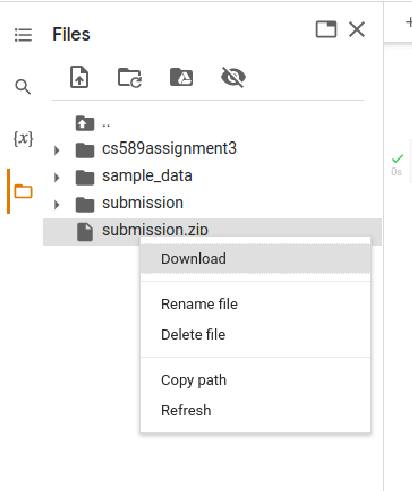